# Exercise 4

Work on this before the next lecture on 26 April. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to your GitHub repository for this course before the next lecture starts and post a link to your repository in [this thread](https://github.com/wildtreetech/advanced-computing-2018/issues/8). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

The overall idea of this exercise is to get you using and building convolutional neural networks.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import utils

%matplotlib inline

## Question 1

In the last exercise you built a neural network that can classify fashion items using only densely connected layers.

Build on this by using convolutions, pooling, dropout, batch norm, etc in your neural network. Can you outperform your densely connected network?

Start with a small network and a fraction of the data to check if you hooked everything up correctly. Don't go overboard with the size of the network either as even small networks take quite a while to train.

(If you want to experiment with a free GPU checkout https://kaggle.com/kernels .)

In [75]:
# Fashion MNIST is built into keras
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# How is the data stored?

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=42)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

num_classes = 10
y_train_ = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
y_train = utils.to_categorical(y_train, num_classes)

print(y_train.shape, y_val.shape, y_test.shape)
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

(50000, 10) (10000, 10) (10000, 10)
Training data shape: (50000, 28, 28, 1)
Training labels shape: (50000, 10)


In [76]:
def plot_example(name, X, y):
    
    X = X[..., -1]
    
    names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    label = names.index(name)
    where = np.where(y == label)
    number = np.random.randint(0, len(where[0]) - 1)
    number = where[0][number]
    
    plt.figure()
    plt.imshow(X[number], cmap='gray')
    plt.title("This is a %s" % name);

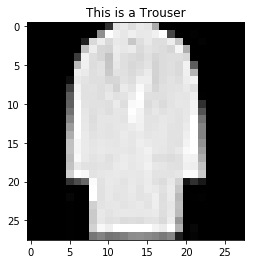

In [77]:
plot_example('Trouser', X_train, y_train)

In [78]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [103]:
input_layer = Input(shape=(28, 28, 1))

x = Convolution2D(5, (8, 8), activation='relu', padding='same')(input_layer)
x = Convolution2D(5, (8, 8), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)

x = Convolution2D(10, (4, 4), activation='relu', padding='same')(x)
x = Convolution2D(10, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)

x = Convolution2D(20, (2, 2), activation='relu', padding='same')(x)
x = Convolution2D(20, (2, 2), activation='relu', padding='same')(x)

x = Flatten()(x)
# we want to predict one of ten classes
# x = Dense(200, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dropout(0.5)(x)
x = Dense(20, activation='relu')(x)
y = Dense(10, activation='softmax')(x)

# Package it all up in a Model
net = Model(input_layer, y)
net.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['categorical_accuracy'])

In [ ]:
n_samples = 50000
batch_size = 1000 # n_samples // 10 
history = net.fit(X_train[:n_samples], y_train[:n_samples],
                  batch_size=batch_size,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 127s 3ms/step - loss: 0.6803 - categorical_accuracy: 0.7525 - val_loss: 0.6072 - val_categorical_accuracy: 0.7782
Epoch 2/20
50000/50000 [==============================] - 130s 3ms/step - loss: 0.6707 - categorical_accuracy: 0.7570 - val_loss: 0.6028 - val_categorical_accuracy: 0.7696
Epoch 3/20
50000/50000 [==============================] - 131s 3ms/step - loss: 0.6638 - categorical_accuracy: 0.7594 - val_loss: 0.5950 - val_categorical_accuracy: 0.7891
Epoch 4/20
50000/50000 [==============================] - 127s 3ms/step - loss: 0.6495 - categorical_accuracy: 0.7629 - val_loss: 0.5828 - val_categorical_accuracy: 0.7813
Epoch 5/20
30000/50000 [=================>............] - ETA: 48s - loss: 0.6471 - categorical_accuracy: 0.7647

In [111]:
def plot_history(history):

    epoch = history.epoch
    metrics = history.history

    plt.figure()
    plt.plot(epoch, metrics['loss'], label='train loss')
    plt.plot(epoch, metrics['val_loss'], label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('categorical_crossentropy')
    plt.legend()

    plt.figure()
    plt.plot(epoch, metrics['categorical_accuracy'], label='train accuracy')
    plt.plot(epoch, metrics['val_categorical_accuracy'], label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('categorical_accuracy')
    plt.legend()

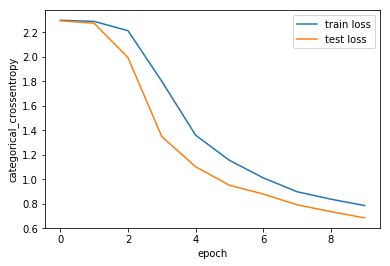

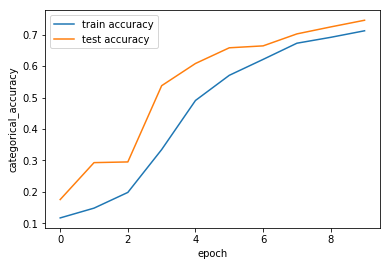

In [112]:
plot_history(history)

## Question 2

For most real world applications we do not have enough labelled images to train a large neural network from scratch. Instead we can use a pre-trained network as a feature transformer and train a smaller model (or even just a logistic regression) on the output of the pre-trained network.

There are several pretrained networks available as part of keras: https://keras.io/applications/. The documentation usually gives some information or links about each network.

The documentation also contains snippets on how to use a pre-trained network as feature transformer ("Extract features with VGG16"). You should be able to generalise from that example using VGG16 to approximately any of the networks available there.

One important thing to not forget is that you need to preprocess your images before feeding them into a pretrained network. Keras provides the functions to do that as well, use them :) You might also need to resize your images first.

The task for this question is to build a classifier that can tell road bikes from mountain bikes. Start with using a pre-trained network as feature transformer and logistic regression as classifier on the output of the pretrained network. Once this works you can experiment with extracting features from earlier layers of the pre-trained network, compare your performance to a small network trained from scratch, try to beat your neural net by extracting features by hand and feeding them to a random forest, increasing your dataset size by [augmenting the data](https://keras.io/preprocessing/image/), etc.

The dataset containing about 100 labelled images for each road and mountain bikes is here: https://github.com/wildtreetech/advanced-computing-2018/blob/master/data/road-and-mountain-bikes.zip

In [ ]:
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np


# for example load the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

## Question 3

Think about what project you want to do. What makes a good project? It should use some of what you learnt in this class, there should be labelled data available already, and it should be something you are interested in.

You will have to write a short report on what you did. To write an interesting report you need to tell a story, not just first I did A, then I did B, then I did X and finally D.

It also has to go a bit beyond simply training a classifier or regression model.

An example based on the bike images from the previous question:

A local bike shop wants to keep an eye on sales of bikes on ebay. They specialise in road bikes so they want to be able to filter out all adverts for mountain bikes. They have found that people writing ebay adverts are not very good at correctly labelling their adverts. Can they use machine-learning to help classify adverts?

We investigate labelling adverts based on the image in the advert and study different trade offs in misclassifying bikes. The network was trained on 100 images from a catalog which show bikes on a white background. We compare the performance of the network on the training data and a small set of hand labelled images of bikes in the wild.